In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import nomad.io.base as loader
import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street
import geopandas as gpd

## Load street geometries

In [2]:
streets = gpd.read_file("Streets_Arterials.geojson").to_crs("EPSG:3857")

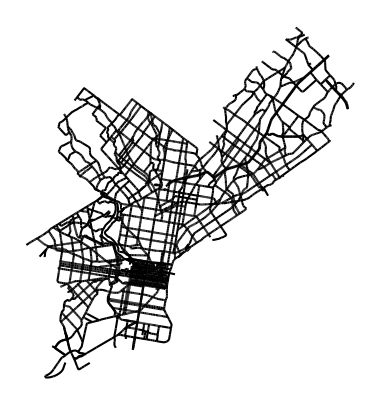

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

streets.plot(ax=ax, edgecolor="black")
plt.show()

## Bounding box for old city

In [4]:
bbox = box(-75.16620602283949, 39.94115823455355, -75.14565573634475, 39.955720193879245)
old_city = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326").to_crs("EPSG:3857")

In [19]:
x_mean, y_mean = old_city.geometry.iloc[0].centroid.xy
x_mean, y_mean = x_mean[0], y_mean[0]

In [21]:
x_mean

-8366319.955610658

## Rotate streets 10 deg, then clip to old city bbox

In [27]:
rot_streets = streets.assign(geometry=streets.geometry.rotate(9, origin=(x_mean, y_mean) ) )
rot_streets = gpd.GeoDataFrame(rot_streets)

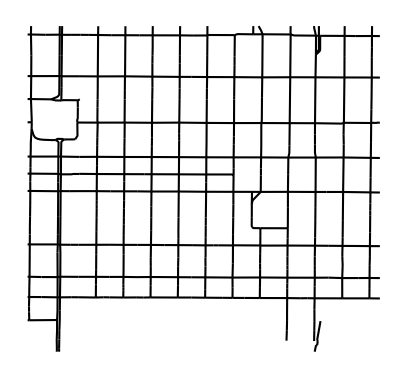

In [51]:
clipped_streets = gpd.clip(rot_streets, old_city)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

clipped_streets.plot(ax=ax,edgecolor="black")

plt.show()

## Simplify and remove weird streets

In [60]:
from shapely.geometry import LineString, LinearRing

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

segments = clipped_streets.geometry.apply(segments)
segments = gpd.GeoSeries([s for seg_list in segments for s in seg_list ])

In [64]:
segments = segments.loc[segments.length>20]

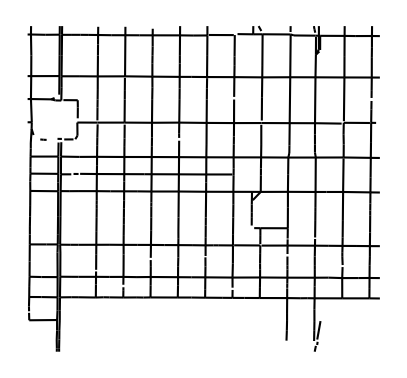

In [65]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

segments.plot(ax=ax,edgecolor="black")

plt.show()

# Parks in PHiladelphia

In [89]:
import osmnx as ox

# Overpass bbox is S,W,N,E but OSMnx.features_from_bbox takes (north, south, east, west)

west  = -75.16620602283949
south =  39.94115823455355
east  = -75.14565573634475
north =  39.955720193879245

bbox = (west, south, east, north)  # (left, bottom, right, top)
parks = ox.features_from_bbox(bbox=bbox, tags={"leisure": "park"}).to_crs("EPSG:3857")

parks.to_file("phl_parks_osmnx.geojson", driver="GeoJSON")

### Rotate and clip parks

In [90]:
rot_parks = parks.assign(geometry=parks.geometry.rotate(9, origin=(x_mean, y_mean) ) )
rot_parks = gpd.GeoDataFrame(rot_parks)

clipped_parks = gpd.clip(rot_parks, old_city)

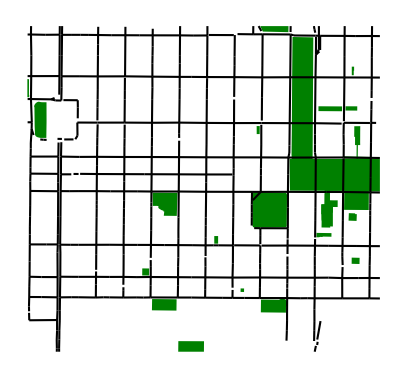

In [94]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

clipped_parks.plot(ax=ax,color="green")
segments.plot(ax=ax,edgecolor="black")

plt.show()

